In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

import sqlite3

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import split_images
reload(split_images)
from split_images import split_geometry, haversine, calc_segment_count

In [3]:
from analysis_image import AnalysisImage
from keras.preprocessing import image

In [4]:
ee.Authenticate()
ee.Initialize()

In [5]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
# FEATURES = ['B2', 'B3', 'B4']

In [55]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [56]:
tegu_200_eloisa = None

In [57]:
# Load eloisa_databases/tegu_200x200_flatten.pkl
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'rb') as f:
    tegu_200_eloisa = pickle.load(f)

tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [8]:
from tensorflow.keras.applications import ResNet152V2 as resnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_p

In [9]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

In [36]:
tegu_200_eloisa.extract_features_multiyear(years=years, model=resnet, preprocess_input=resnet_p)

650/650 ━━━━━━━━━━━━━━━━━━━━ 4120s 6s/step


In [37]:
tegu_200_eloisa.update_database()

In [ ]:
tegu_200_eloisa.vacuum_db()

In [54]:
tegu_200_eloisa.scale_features(years=years, model=resnet)

MemoryError: Unable to allocate 2.54 GiB for an array with shape (3468, 98148) and data type float64

In [26]:
tegu_200_eloisa.pca_features(years=years, model=resnet, n_components=1251, plot_variance=True, chunk_size=2000)

In [ ]:
tegu_200_eloisa.pca_features(years=years, model=resnet, variance_min=0.95, plot_variance=True, chunk_size=2000)

MemoryError: Unable to allocate 14.6 GiB for an array with shape (20001, 98148) and data type float64

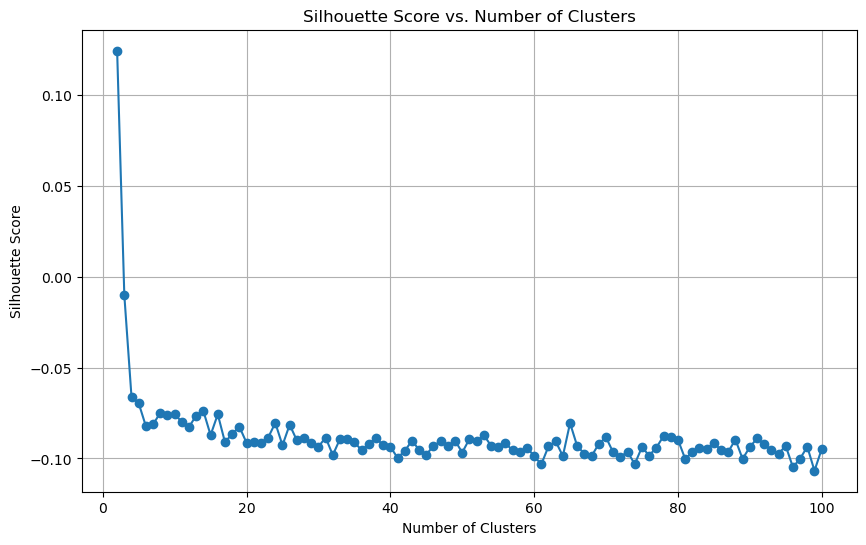

In [43]:
sil = tegu_200_eloisa.calc_silhouette_score(years=years, model=resnet, show_plot=True)

In [87]:
# Print the highest score found in the list sil
print(max(sil[1:]))

# Print the index of the highest score found in the list sil
print(sil.index(max(sil[1:])))

0.007939352
1


c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412:

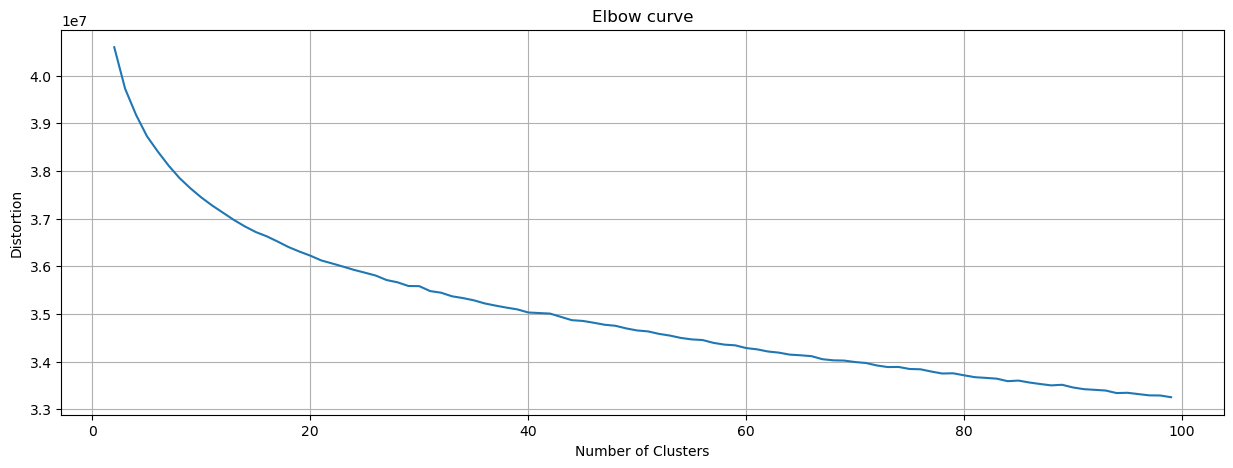

In [42]:
tegu_200_eloisa.plot_elbow_curve(years=years, model=resnet)

# CUTOFF

In [27]:
tegu_200_eloisa.calc_kmeans_clusters(years=years, model=resnet, n_clusters=75)

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


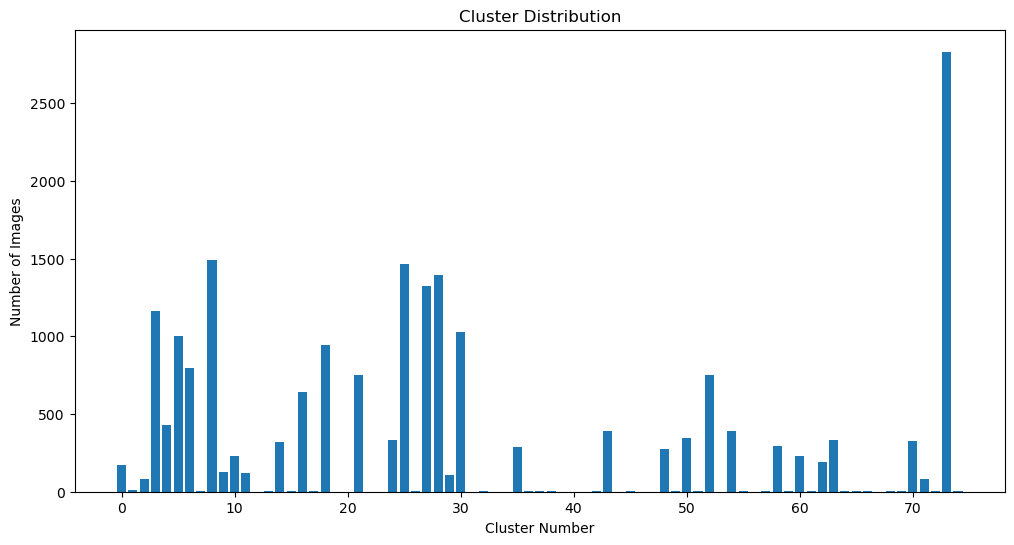

In [28]:
tegu_200_eloisa.plot_cluster_counts(years=years, model=resnet)

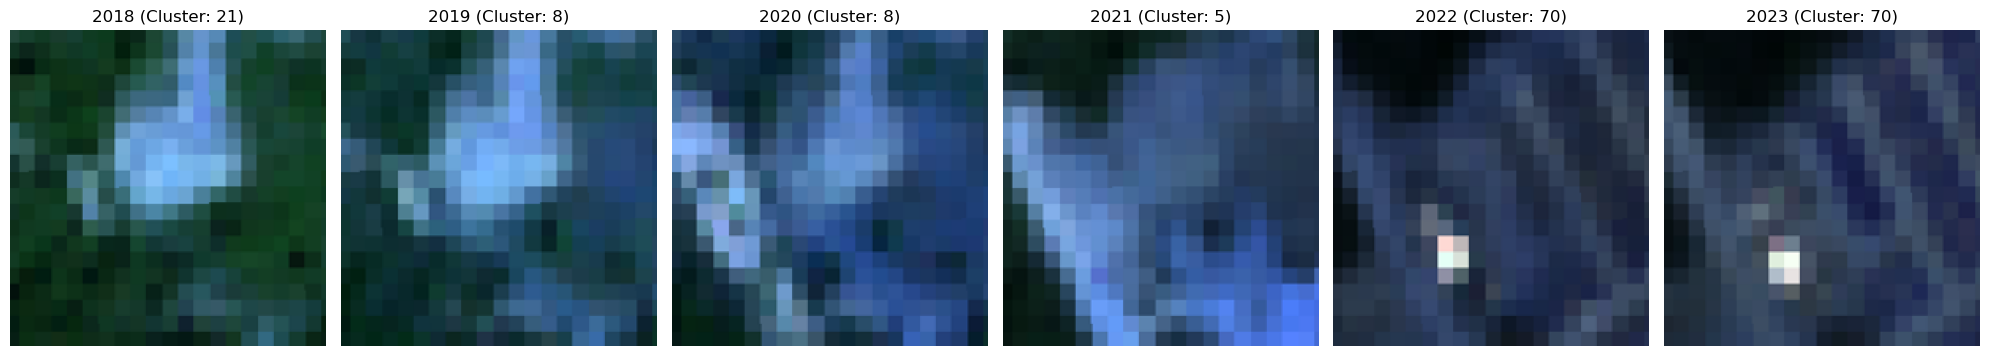

In [44]:
tegu_200_eloisa.show_clip_by_year(years=years, index=1, model=resnet)

In [30]:
# tegu_200_eloisa.update_database()

In [31]:
# tegu_200_eloisa.close_db()

# Delete database using os.remove() method
# os.remove(tegu_600_eloisa.db_path)

## Cluster Metric Testing

In [32]:
import cluster_tester
reload(cluster_tester)
from cluster_tester import ClusterTester

In [33]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

subgeometries = split_geometry(tegucigalpa_image.geometry_sd, x_num_parts=x_num_parts, y_num_parts=y_num_parts)

In [34]:
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [35]:
# Get cluster location multipolygons
cluster_location_info = tegu_200_eloisa.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=True)

In [36]:
tegu_cluster_tester = ClusterTester(cluster_location_info=cluster_location_info, analysis_image=tegucigalpa_image, validation_data=precario_gdf)

In [37]:
tegu_cluster_tester.plot_clusters()

Map(center=[14.0763396, -87.20787405], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [38]:
points = tegu_cluster_tester.create_sampling_points(n_points=5000)

In [39]:
cluster_metrics = tegu_cluster_tester.calc_sampling_metrics()

In [40]:
grouped_metrics = tegu_cluster_tester.group_clusters_and_calc_metrics(precision_min=0.15)

100%|██████████| 31/31 [00:01<00:00, 25.96it/s]


In [41]:
# Sort by f1 and print head, only show up to sig fig 2
grouped_metrics.sort_values(by='F1', ascending=False).head()

,combination,precision,recall,F1
30,"[73, 0, 29, 37, 72]",0.225000,0.457926,0.301741
26,"[73, 0, 29, 72]",0.224254,0.455969,0.300645
27,"[73, 0, 37, 72]",0.225490,0.450098,0.300457
25,"[73, 0, 29, 37]",0.223507,0.454012,0.299548
17,"[73, 0, 72]",0.224730,0.448141,0.299346


In [42]:
tegu_cluster_tester.plot_top_cluster_combos(metric='F1', n_combos=1)

Map(center=[14.0763396, -87.20787405], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…